In [1]:
from labeyrieClasses import target #, fftw_psd
import numpy as np
import matplotlib.pyplot as plt
import ctypes


%matplotlib inline

In [2]:
# Import fits data
binary = target()
binary.fits.fileName = "/home/niels/Documents/FITS/KP330.fits"
binary.fits.read(numDimensions = 3)

# Import shared C library
fftw_psd_dll = ctypes.CDLL('/home/niels/Dropbox/Thesis/Python/dev/fftw_psd.so')

# Image sizing parameters
imgsize = 512
psd_n = imgsize*(int(imgsize/2)+1)
img_n = imgsize**2

Filename: /home/niels/Documents/FITS/KP330.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      62   (512, 512, 1000)   float32   
None


In [3]:
# FFTW PSD Function Declaration
def fftw_psd(input_img):
    # Reshape Square array to be flat
    input_img_flat = np.reshape(input_img.astype(np.float32),(imgsize**2,1))

    # Create pointers for in/out
    img_ptr = (input_img_flat).ctypes.data_as(ctypes.POINTER(ctypes.c_float))
    out_ptr = (np.zeros(img_n,np.float32)).ctypes.data_as(ctypes.POINTER(ctypes.c_float))
    # Array type to be passed to wrapped C function
    # Set input argument to be flat array of doubles (# of input img pixels)
    fftw_psd_dll.psd.argtypes = [ctypes.POINTER(ctypes.c_float)]
    fftw_psd_dll.psd.restype = ctypes.POINTER(ctypes.c_float * psd_n)

    # Calculate PSD, get a pointer returned
    out_ptr = fftw_psd_dll.psd(img_ptr)

    # Reshape array to image
    psd_image = np.reshape(out_ptr.contents,(imgsize,int(imgsize/2+1)))
    
    # Return PSD Image
    return psd_image

In [ ]:
# Calculate Average using NP and FFTW function
fftw_psd_img = np.zeros((imgsize,int(imgsize/2+1)))
np_psd_img = np.zeros((imgsize,imgsize))

for image in binary.fits.data:
    #plt.imshow(image)
    fftw_psd_img += fftw_psd(image)
    np_psd_img += (np.abs(np.fft.fft2(image))**2)

In [ ]:
# Compare PSD images from both FFTW and NP
np_psd_img_shifted = np.fft.fftshift(np_psd_img)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(np.log10(fftw_psd_img))
plt.title("fftw PSD")
plt.subplot(1,2,2)
plt.imshow(np.log10(np_psd_img))
plt.title("numpy fft psd")

plt.figure(figsize=(10,10))
plt.imshow(np.log10(np_psd_img_shifted))

In [ ]:
# Looking for symmetry in PSD images
indices = ((0,0), 
           (1,1), 
           (511,511), 
           (2,2),
           (510,510),
           (1,2),
           (512-1,512-2),
           (257,0),
           (255,0))

print("\n Showing example values")
for index in indices:
    print("index = ", index, " \t np_psd_img = ", np_psd_img[index])
    

print("\n Showing symmetry along first column")
for i in np.arange(5):
    print("np_psd_img[", 256+i, ",0 ] = ", np_psd_img[256+i,0], 
          "np_psd_img[", 256-i, ",0 ] = ", np_psd_img[256-i,0])
    print("Difference = ", np_psd_img[256+i,0]-np_psd_img[256-i,0] )
    
    
print("\n Showing symmetry along first row")
for i in np.arange(5):
    print("np_psd_img[ 0,", 256+i, "] = ", np_psd_img[0,256+i], 
          "np_psd_img[ 0,", 256-i, "] = ", np_psd_img[0,256-i])
    print("Difference = ", np_psd_img[0,256+i]-np_psd_img[0,256-i] )    

# We see symmetry at (1,1) and (511,511)

print("\n Show extreme values transposition loop will index through")
y_range = np.arange(1,imgsize)
x_range = np.arange(int(imgsize/2)+1,imgsize)
print("Y Max = ", y_range.max(), ", Y Min = ", y_range.min())
print("X Max = ", x_range.max(), ", X Min = ", x_range.min())


In [ ]:

print("Test Transposing Algorithm")
(y_destination,x_destination) = (257,257)
(y_source,x_source) = (imgsize-y_destination,imgsize-x_destination)

print("Destination: ", y_destination,x_destination)
print("Source: ", y_source,x_source)
print("Difference = ", np_psd_img[y_destination,x_destination] - np_psd_img[y_source,x_source])

From : http://www.fftw.org/doc/Multi_002ddimensional-Transforms.html


Y[k0, k1, ..., kd-1] = Y[n0 - k0, n1 - k1, ..., nd-1 - kd-1]*

In [4]:
def transpose_fftw_psd(fftw_psd_img):
    # Calculate Image Dimensions
    imgsize = np.shape(fftw_psd_img)[0]
    # Create a padded version of original image
    fftw_psd_img_padded = np.lib.pad(fftw_psd_img, ((0, 0), (0, int(imgsize/2-1))), 'constant')

    # Loop through first row
    y = 0
    y_source = 0
    for x in np.arange(int(imgsize/2)+1,imgsize):
        x_source = imgsize-x
        fftw_psd_img_padded[y,x] = fftw_psd_img_padded[y_source,x_source]    
    
    # Loop through rest of image
    for y in np.arange(1,imgsize):
        for x in np.arange(int(imgsize/2)+1,imgsize):
            y_source = imgsize-y
            x_source = imgsize-x
            fftw_psd_img_padded[y,x] = fftw_psd_img_padded[y_source,x_source]

    return fftw_psd_img_padded

In [ ]:
fftw_psd_img_padded = transpose_fftw_psd(fftw_psd_img)

acorr_np = np.real(np.fft.fftshift(np.fft.ifft2(np_psd_img)))
acorr_fftw = np.real(np.fft.fftshift(np.fft.ifft2(fftw_psd_img_padded)))

plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(np.log10(np.fft.fftshift(np_psd_img)))
plt.title("Numpy PSD")
plt.subplot(1,2,2)
plt.imshow(np.log10(np.fft.fftshift(fftw_psd_img_padded)))
plt.title("Shifted FFTW PSD")

plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(acorr_np)
plt.title("Numpy Acorr")
plt.subplot(1,2,2)
plt.imshow(acorr_fftw)
plt.title("Shifted FFTW Acorr")

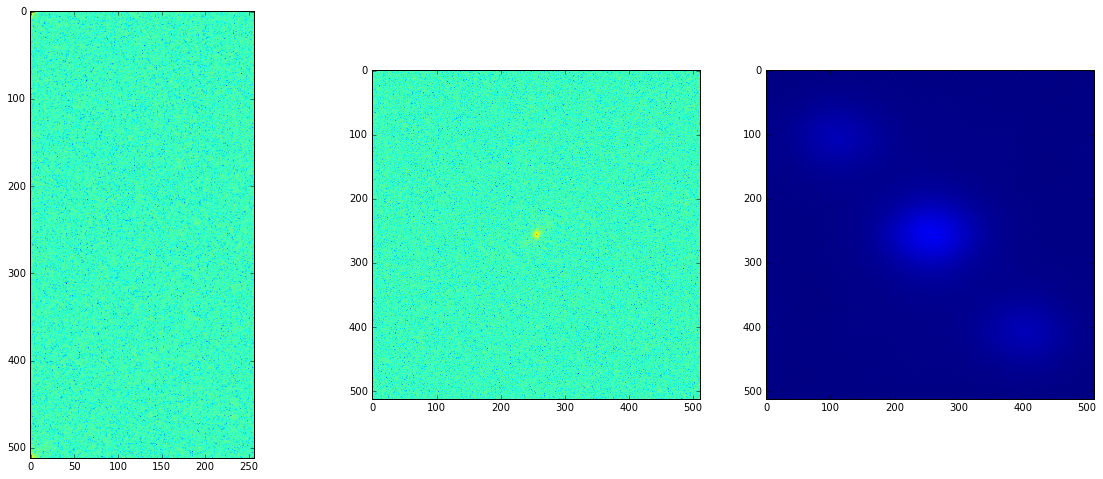

In [5]:
psd_test = fftw_psd(binary.fits.data[0])
psd_full_test = transpose_fftw_psd(psd_test)
acorr_test = np.real(np.fft.fftshift(np.fft.ifft2(psd_full_test)))

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.imshow(np.log10(psd_test))
plt.subplot(1,3,2)
plt.imshow(np.log10(np.fft.fftshift(psd_full_test)))
plt.subplot(1,3,3)
plt.imshow(acorr_test)